In [46]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io as sio
import os
import json

from scipy.stats import linregress

from multiprocessing import Pool

from tqdm import tqdm

from time import time

from init import get_maind

from core import tuplinator, init_Frame, SSub_ntau, twodim_graphs, name_toidx, reduceCS, get_maind, obs_path

**Get the master dictionary defined in init.py (and save it)**

In [4]:
maind = get_maind(save = True)

**Load Backward Masking dataset infos**

In [10]:
#Data paths

# Dataset name
exp_name = 'bmasking'

#Workflow folder path
wf_path = maind['path']

#Backward Masking dataset path
bw_path = maind[exp_name]['directories']['data']

#Channel names
ch_list = maind[exp_name]['pois']

# Useful clusters

# Parieto-Occipital and Frontal
ch_clust = ['O2','PO4','PO8'],['Fp1','Fp2','Fpz']

ch_list_idx = name_toidx(ch_list, exp_name = exp_name)
ch_clust_idx = name_toidx(ch_clust, exp_name = exp_name)

**Transform data in evoked format for easier data fetching**

*To do this, launch the BMtoMNE.py script*

**Check $C(m,r)$ very average behaviour**

For new results, edit the script and run *'python -m corrsum'* in the console.

In [19]:
# Load results of corrsum.py script

# Legend

#Axis 0 = Subjects
#Axis 1 = Conditions
#Axis 2 = Electrodes
#Axis 3 = m: Embedding dimension
#Axis 4 = r

lb = 'G20'

# Load results from correlation.py script
CS = np.load(wf_path + 'results/BM/CS/' + lb + '/CSums.npy')
r = np.load(wf_path + 'results/BM/CS/' + lb + '/rvals.npy')

print(CS.shape)

with open(wf_path + 'results/BM/CS/' + lb + '/variables.json', 'r') as f:
    vars = json.load(f)

embs = vars['embeddings']

(36, 2, 62, 19, 20)


**Plot the most average data you can think of**

(36, 2, 62, 19, 20)


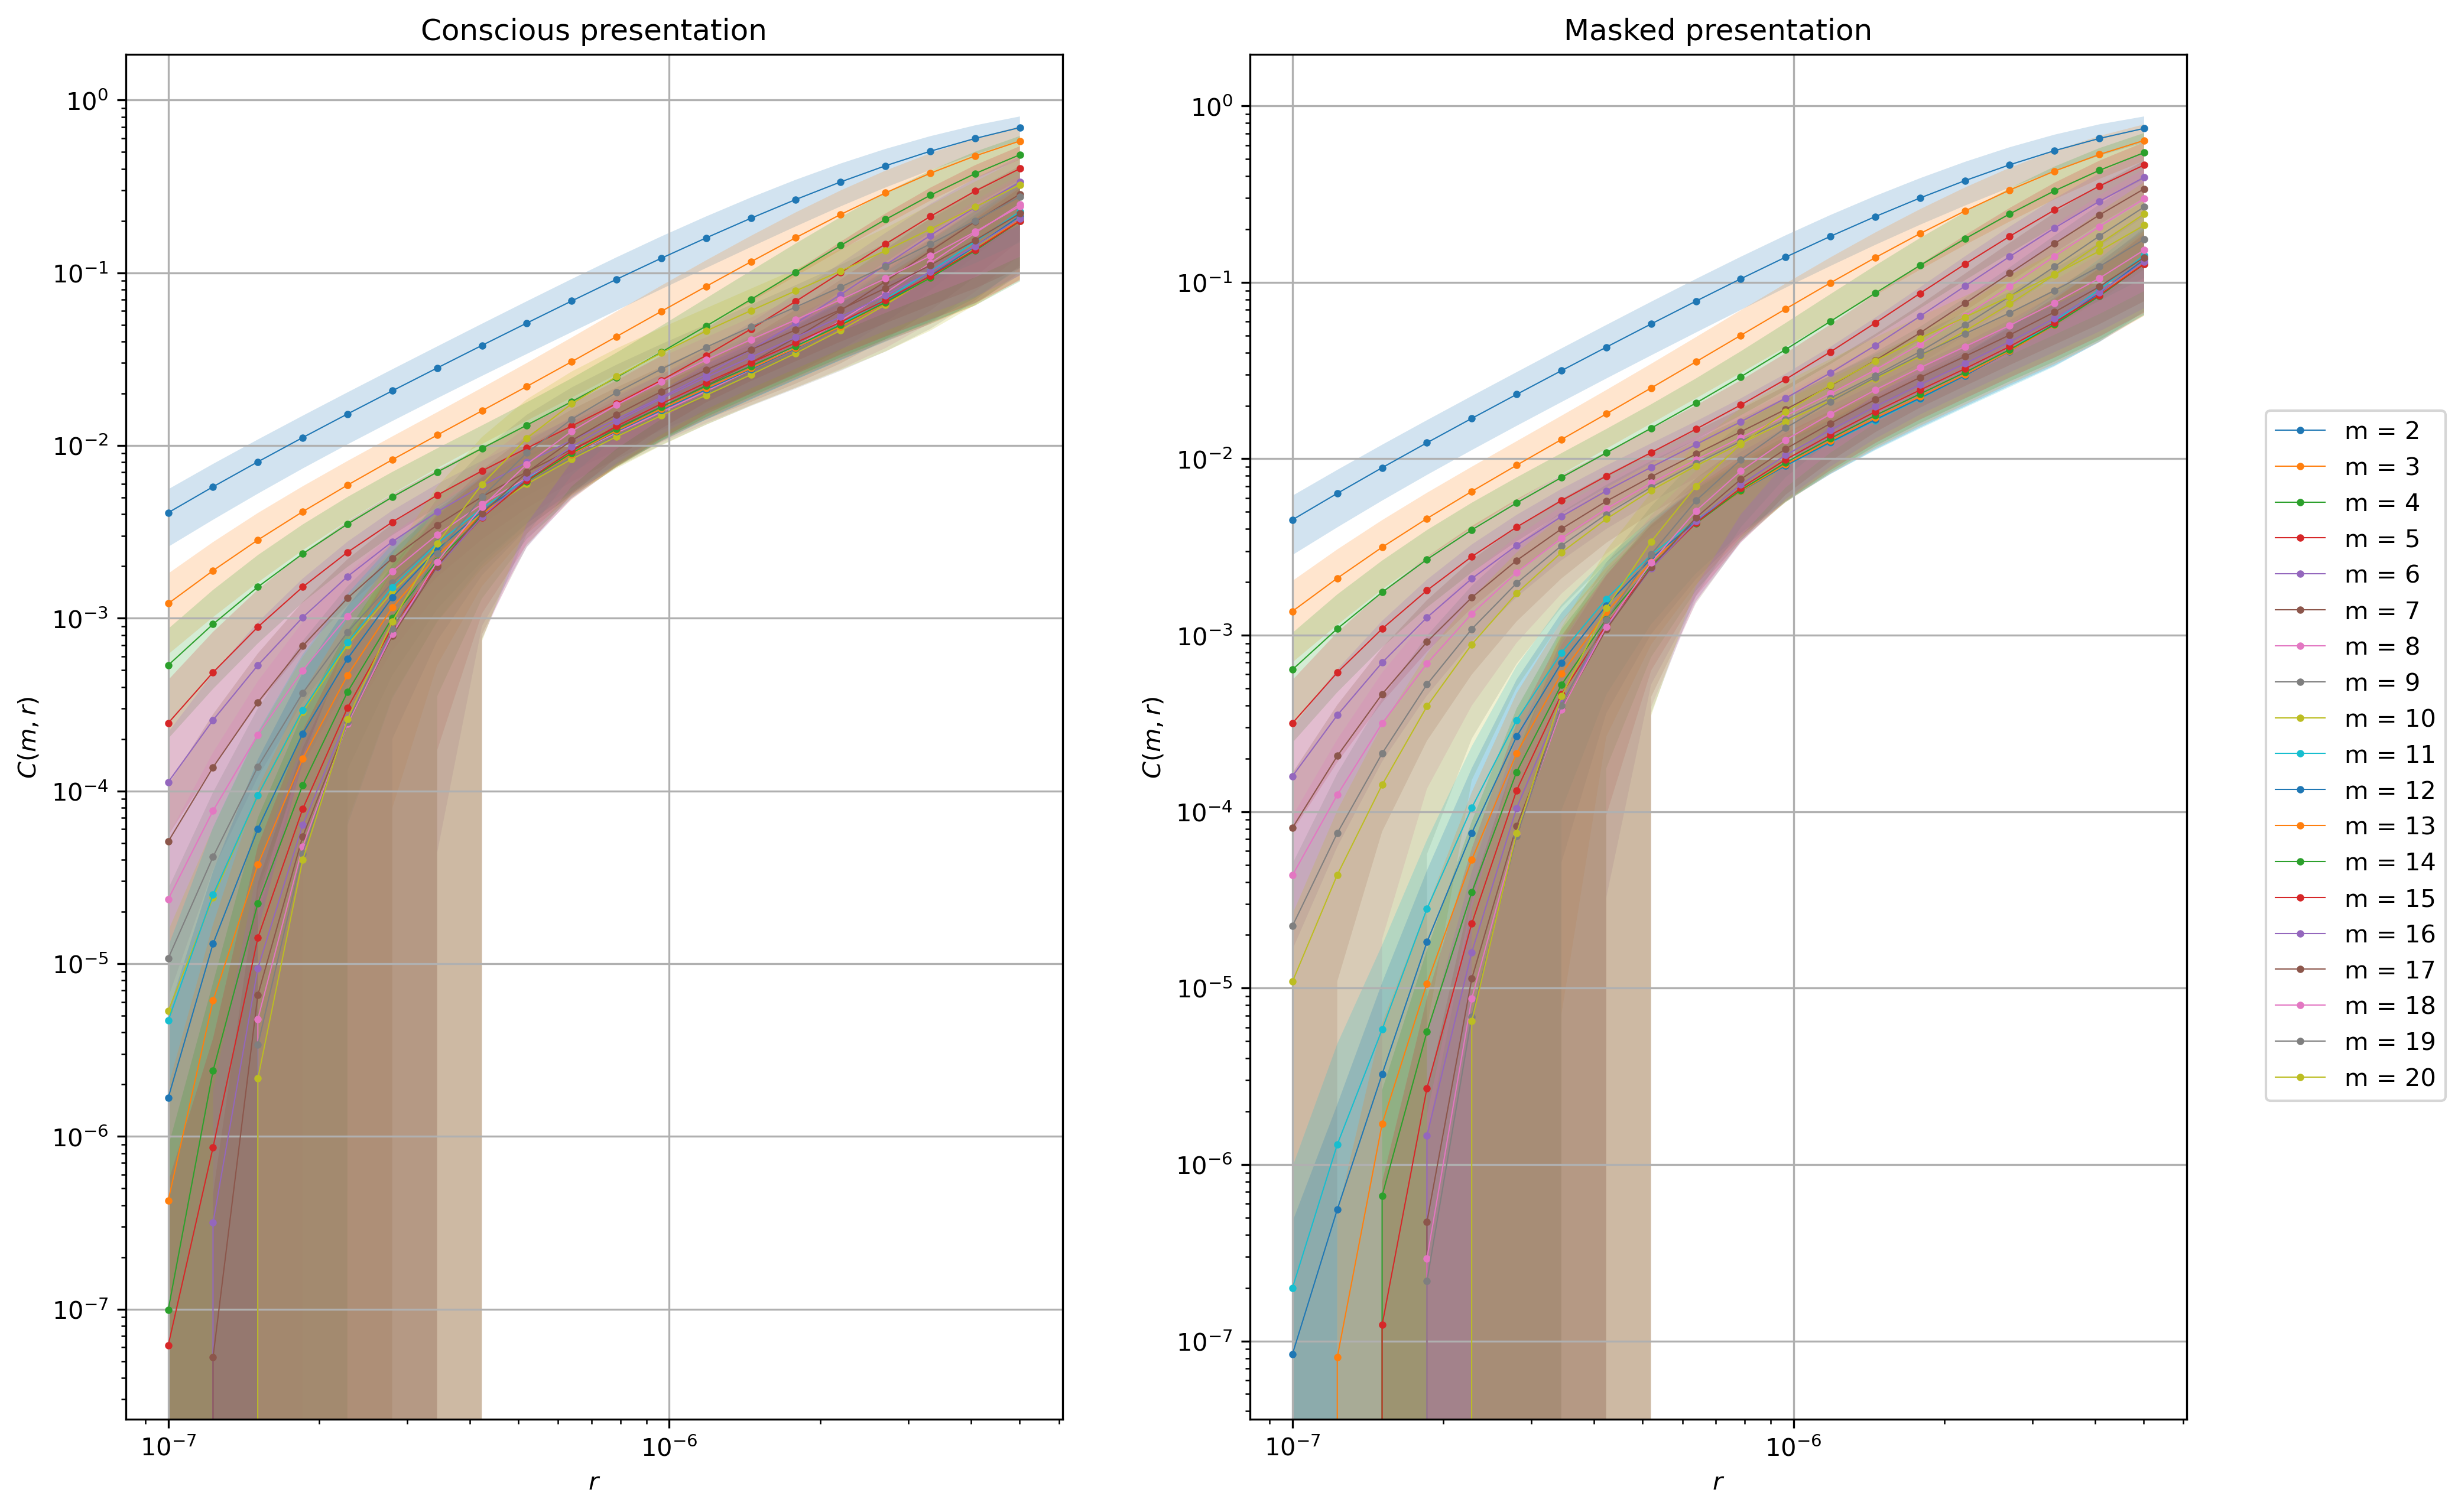

In [ ]:
# Average data and print plots with std error area

# Get average across subjects across channels (for now)
CS = CS.mean(axis = 0)

CScon = CS[0,:,:,:]
CSunc = CS[1,:,:,:]

CScon_std = CScon.std(axis = 0)
CSunc_std = CSunc.std(axis = 0)

CScon = CScon.mean(axis = 0)
CSunc = CSunc.mean(axis = 0)

fig, axs = plt.subplots(1,2, figsize = (15,10), dpi = 300)

for i, c in enumerate(CScon):
    axs[0].plot(r, c, marker = 'o', markersize = 2, linewidth = 0.5, label = 'm = ' + str(embs[i]))
    axs[0].fill_between(r, c - CScon_std[i,:],c + CScon_std[i,:], alpha = 0.2)

axs[0].set_title('Conscious presentation')

for i, c in enumerate(CSunc):
    axs[1].plot(r, c, marker = 'o', markersize = 2, linewidth = 0.5)#, label = 'm = ' + str(embs[i]))
    axs[1].fill_between(r, c - CSunc_std[i,:],c + CSunc_std[i,:], alpha = 0.2)

axs[1].set_title('Masked presentation')

for ax in axs:
    ax.grid()

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel('$r$')
    ax.set_ylabel('$C(m,r)$')

fig.legend(loc = 'center right')
plt.savefig(wf_path + 'pics/BM/' +  lb + '_averageCsum.png', dpi = 300)
plt.show()

**Results of the Grassberger-Procaccia algorithm for $D^{2}$**

For new results, edit the script and run *'python -m idim'* in the console.

In [40]:
# Load results from idim.py script

# Legend

#Axis 0 = Subjects
#Axis 1 = Conditions
#Axis 2 = Electrodes
#Axis 3 = m: Embedding dimension
#Axis 4 = r

lb = 'CPOF'

# Load source results from corrsum.py script
CS = np.load(wf_path + 'results/BM/CS/' + lb + '/CSums.npy')
r = np.load(wf_path + 'results/BM/CS/' + lb + '/rvals.npy')

print(CS.shape)

with open(wf_path + 'results/BM/CS/' + lb + '/variables.json', 'r') as f:
    vars = json.load(f)

embs = vars['embeddings']

# Fit parameters
vmin = 5
vmax = 28

# Averaged data
avg = ''

m = np.load(wf_path + 'results/BM/D2/' + lb + '/' + avg + str(vmin) + '_' + str(vmax) + 'slopes.npy')
em = np.load(wf_path + 'results/BM/D2/' + lb + '/' + avg +  str(vmin) + '_' + str(vmax) + 'errslopes.npy')

(36, 2, 2, 9, 20)


**Select just for Parieto-Occipital and Frontal electrodes**

*Reduce $C(m,r)$ over electrodes in clusters and set result idim.py script to average over electrodes*

*Run this cell if global correlation sum is already calculated or a launch new script(slower)*

In [ ]:
# Create new directory with appropriate labeling

# Parieto-Occipital electrodes
lb = 'PO'
pois = ['O2','PO4','PO8']

__ = reduceCS(ch_list = pois, path = wf_path + 'BM_CS/', nlabel = lb)

# Frontal electrodes
lb = 'F'
pois = ['Fp1','Fp2','Fpz']

__ = reduceCS(ch_list = pois, path = wf_path + 'BM_CS/', nlabel = lb)

**Make a dictrionary for results label to text**

In [45]:
clust_dict = {'G': 'Global (m $\\le$ 10)',
              'G20': 'Global (m $\\le$ 20)',
              'PO': 'O2, PO4, PO8',
              'F': 'Fp1, Fp2, Fpz',
              'CPOF': ['O2, PO4, PO8','Fp1, Fp2, Fpz']}

**Load results idim.py script**

*Change the label variable appropriately when running*

In [49]:
# Legend

#Axis 0 = Subjects
#Axis 1 = Conditions
#Axis 2 = Electrodes
#Axis 3 = m: Embedding dimension
#Axis 4 = r

# Experiment label
exp_label = 'bmasking'

# Results label
lb = 'CPOF'

cs_path = obs_path(exp_name = exp_name, obs_name = 'corrsum', res_lb = lb)

# Load source results from corrsum.py script
CS = np.load(cs_path + 'CSums.npy')
r = np.load(cs_path + 'rvals.npy')

print(CS.shape)

# Load result variables
with open(cs_path + 'variables.json', 'r') as f:
    variables = json.load(f)

embs = variables['embeddings']
clst = variables['clustered']

# Fit parameters
vmin = 5
vmax = 28

avg = ''

# logfit.py results label
ld_lb = avg  + str(vmin) + '_' + str(vmax)

# Load results from idim.py script

d2_path = obs_path(exp_name = exp_name, obs_name = 'idim', res_lb = lb)

m = np.load(d2_path + ld_lb + 'slopes.npy')
em = np.load(d2_path + ld_lb + 'errslopes.npy')

print(m.shape)

(36, 2, 2, 9, 20)
(36, 2, 2, 9)


**Plot average $D_{2}(m)$ per subject**

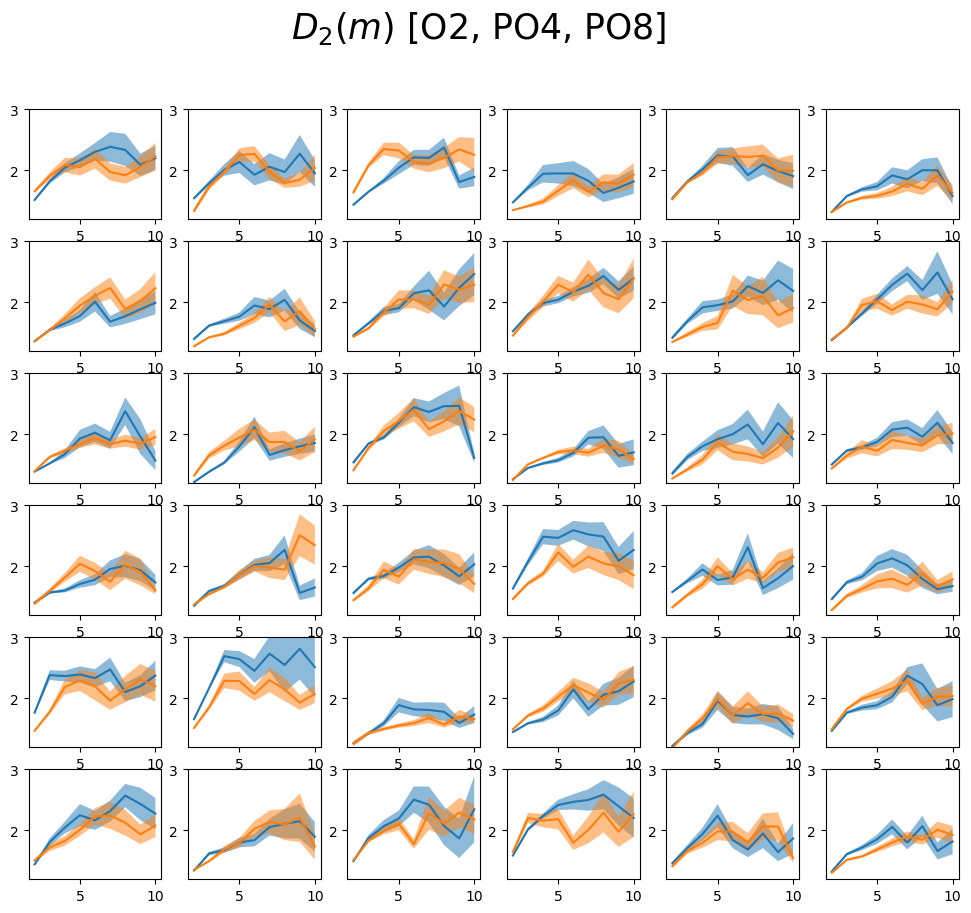

In [51]:
# Check expected attractor dimension 

# Make appropriate labeling
sv_lb = lb

if clst == True:
    cl_idx = 0
    M = m[:,:,cl_idx,:]
    EM = em[:,:,cl_idx,:]

    sv_lb = lb + str(cl_idx)

    title = '$D_{2}(m)$ [' + clust_dict[lb][cl_idx] + ']'

else:
    M = m.mean(axis = 2)
    EM = em.mean(axis = 2)

    sv_lb = lb

    title = '$D_{2}(m)$ [' + clust_dict[lb] + ']'

fig, axs = plt.subplots(6,6, figsize = (12,10))

for j, ax in enumerate(axs.flat):
    
    ax.plot(embs, M[j,0,:], label = 'Conscious')
    ax.fill_between(embs, M[j,0,:]-EM[j,0,:], M[j,0,:]+EM[j,0,:], alpha = 0.5)

    ax.plot(embs, M[j,1,:], label = 'Unconscious')
    ax.fill_between(embs, M[j,1,:]-EM[j,1,:], M[j,1,:]+EM[j,1,:], alpha = 0.5)

    ax.set_ylim(1.2,3)
    #ax.set_title(sub_list[j])

fig.suptitle(title, size = 25)

plt.savefig(wf_path + 'pics/BM/'+ sv_lb + avg +'_Dattractor.png', dpi = 300)

fig.show()

*Following cells do not take advantage of MNE data structure*

***Integration will follow***

**Print 2-dim Time Embedding trajectories**

In [ ]:
###Set parameters

#Time delay
tau = 20

#Number of datapoints to ignore from start and end of signals
trim = 0

#Experiment conditions to pull from
conditions = ['S__','S_1']

#POIs (Put a function here at some point)
poi_idx = ch_clust_idx

#Initialize directory
os.makedirs('./pics/backward_masking/2dim_emb/', exist_ok = True)

###Multiprocessing

#Create iterable function
def Sub_2dimPics(subID):

    twodim_graphs(subID, tau = tau, trim = trim, conditions = conditions, channels_idx = poi_idx)

    return

#Set multiprocessing parameters
workers = 2
chk_size = int(len(sub_list)/workers) + 1

#Run calculations
if __name__ == '__main__':
    with Pool(workers) as p:
        p.map(Sub_2dimPics, sub_list, chk_size)


**Calculate and save optimal $\tau$ and $n$ for Time Embedding**

In [ ]:
###Set parameters

#Metrics calculated by SSub_ntau
metrics = ['t', 'n']

#Experiment conditions to pull from
conditions = ['S__', 'S_1']

#POIs
poi_idx = ch_clust_idx

#Initzialize dataframe for results
df = init_Frame(conditions, poi_idx, metrics)

###Multiprocess

#Create iterable function
def Sub_Results(subID):

    rs = SSub_ntau(subID, conditions = conditions, channels_idx = poi_idx)

    return rs

#Set multiprocessing parameters
workers = 2
chk_size = int(len(sub_list)/workers) + 1

#Run calculations
if __name__ == '__main__':
    with Pool(2) as p:
        rows = p.imap(Sub_Results, sub_list, chk_size)

        i = 0
        for row in rows:

            df.loc[i] = row

            i = i +1

###Save results
df.to_csv(bw_path + str(len(poi_idx)) + 'pois_TDEMBparams.csv', sep = ';', index = False)

**Plot time signal of POIs**

In [ ]:
#Plotting and gathering files in a smart way (Courtesy of Alessio)

conds = ['S__', 'S_1'] # S__ : conscious, S_1 : unconscious
fig,axs = plt.subplots(6,6, figsize=(12,10))
for i, ax in enumerate(axs.flat):
    print('sub '+str(i))
    sub = sub_list[i]
    folder = '/home/lunis/Documents/EEG/data/backward_masking/subj' + sub + '_band_resample/'
    all_files = os.listdir(folder)
    # cond = 'S_1' # unconscious

    # Loop over conditions (conscious and unconscious)
    for cond in conds:
        my_cond_files = [f for f in all_files if cond in f ]

        # Loop over trials of the present conditions
        all_trials = np.empty((0,451))
        for f in my_cond_files:
            path = folder+f
            # Load the .mat file (adjust the path)
            mat_data = sio.loadmat(path)

            # Inspect the keys in the .mat file
    #         print(mat_data['F'][ch_clust_idx].shape)
            data = mat_data['F'][ch_clust_idx]
    #         plt.plot(data.mean(axis=0))
        #     for e in data:
        #         plt.plot(e)
            all_trials = np.concatenate((all_trials, data.mean(axis=0)[np.newaxis, :]))
#         print(all_trials.shape)
        ax.plot(all_trials.mean(axis=0), label=cond)
        ax.axvspan(150, 250, color='grey', alpha=0.15)
#     ax.legend()
plt.savefig(path + 'plottini_all_sub_18_el.png', dpi=300)